# Results Optiwise inverse dynamics

In [220]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [253]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys

import paper
from phd.visualization.styles import styles
from vessel_manoeuvring_models.KF_multiple_sensors import interpolate_and_insert_all
from phd.visualization.units import units
from phd.visualization.symbols import symbols
from phd.pipelines.regression_VCT.nodes import mirror, add_mirrored
from phd.pipelines.regression_VCT.nodes import subtract_centripetal_and_Coriolis
import matplotlib.ticker as plticker
from vessel_manoeuvring_models import IMO_evaluation
from sklearn.metrics import mean_squared_error, r2_score

In [222]:
ship_name = "optiwise"

In [223]:
#%reload_kedro

#%reload_kedro
#loaders = {f"polynomial rudder {name}":loader for name,loader in catalog.load(f"{ship_name}.models_VCT_polynomial_rudder_MDL").items()}
loaders={}
#loaders["semiempirical rudder"] = catalog.load(f"{ship_name}.models_VCT_MDL")['semiempirical_covered_inertia']
loaders["measured rudder"] = catalog.load(f"{ship_name}.models_measured_rudder_force")['semiempirical_covered_inertia']
loaders["MMG_original"] = catalog.load(f"{ship_name}.models_VCT_MMG_rudder_MDL")["original"]
loaders["MMG_quadratic"] = catalog.load(f"{ship_name}.models_VCT_MMG_rudder_MDL")["quadratic"]
#loaders["MMG_rudder"] = catalog.load(f"{ship_name}.models_VCT_MMG_rudder_MDL")["MMG"]
#loaders.pop('polynomial rudder complex')  # for now...

ship_data = catalog.load(f"{ship_name}.ship_data")

[04/15/25 08:38:59] INFO     Loading data from 'optiwise.models_measured_rudder_force'          ]8;id=494013;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=382061;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.models_VCT_MMG_rudder_MDL'             ]8;id=67459;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=948410;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.models_VCT_MMG_rudder_MDL'             ]8;id=334838;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=989085;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.ship_data' (YAMLDataSet)...            ]8;id=664004;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=959468;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [224]:
models = {name:loader() for name,loader in loaders.items()}
model = models["MMG_quadratic"]

In [225]:
meta_datas_all = catalog.load(f"{ship_name}.test_meta_data")

meta_datas_all = meta_datas_all.groupby('test_type').get_group('zigzag')
mask = meta_datas_all['ship_speed'] > 0.9
meta_datas_all = meta_datas_all.loc[mask].copy()

                    INFO     Loading data from 'optiwise.test_meta_data' (CSVDataSet)...        ]8;id=273579;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=216509;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [226]:
meta_datas = meta_datas_all.loc[[23590, 23591, 23594, 23596]].copy()

## Compare forces

In [227]:
df_VCT = catalog.load(f"{ship_name}.df_VCT_scaled")
#model = catalog.load(f"{ship_name}.models_VCT")['semiempirical_covered_inertia']()
df_VCT_hydro = subtract_centripetal_and_Coriolis(df_VCT=df_VCT, model=model)

                    INFO     Loading data from 'optiwise.df_VCT_scaled' (CSVDataSet)...         ]8;id=977721;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=518078;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [228]:
round = {
    'u':4,
    'v':4,
    'r':3,
    'delta':3,
}

keys_rounded = [f"{key}_round" for key in round.keys()]

for key,decimals in round.items():
    df_VCT_hydro[f"{key}_round"] = np.round(df_VCT_hydro[key], decimals=decimals)

_=[]
for id, meta_data in meta_datas.iterrows():

    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    for key,decimals in round.items():
        df_EKF_smooth[f"{key}_round"] = np.round(df_EKF_smooth[key], decimals=decimals)

    df_EKF_smooth['time'] = df_EKF_smooth.index

    mask = df_EKF_smooth.duplicated(keys_rounded)
    df_ = df_EKF_smooth.loc[~mask]

    points = pd.merge(left=df_, right=df_VCT_hydro, how='inner', left_on=keys_rounded, right_on=keys_rounded, suffixes=('','_vct'))
    points.set_index('time', inplace=True)
    assert points.index.is_unique
    points['id'] = id
    #points_all[id]=points
    _.append(points)

points_all = pd.concat(_)
points_all['id'] = points_all['id'].astype(int)

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=651368;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=790300;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=389315;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=714644;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=935952;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=950506;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=433094;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=165351;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [229]:
eq_X_D = remove_functions(sp.Eq(
            X_D, sp.solve(model.X_eq.subs(model.X_D_eq.rhs, model.X_D_eq.lhs), X_D_)[0]
        ))

eq_Y_D = remove_functions(sp.Eq(
            Y_D, sp.solve(model.Y_eq.subs(model.Y_D_eq.rhs, model.Y_D_eq.lhs), Y_D_)[0]
        ))

eq_N_D = remove_functions(sp.Eq(
            N_D, sp.solve(model.N_eq.subs(model.N_D_eq.rhs, model.N_D_eq.lhs), N_D_)[0]
        ))

In [230]:
eq_X_D

Eq(X_D, -X_{\dot{u}}*\dot{u} + Y_{\dot{r}}*r**2 + Y_{\dot{v}}*r*v + \dot{u}*m - m*r**2*x_G - m*r*v)

In [231]:
eq_Y_D

Eq(Y_D, -X_{\dot{u}}*r*u - Y_{\dot{r}}*\dot{r} - Y_{\dot{v}}*\dot{v} + \dot{r}*m*x_G + \dot{v}*m + m*r*u)

In [232]:
eq_N_D

Eq(N_D, I_z*\dot{r} - N_{\dot{r}}*\dot{r} - N_{\dot{v}}*\dot{v} + X_{\dot{u}}*u*v - Y_{\dot{r}}*r*u - Y_{\dot{v}}*u*v + \dot{v}*m*x_G + m*r*u*x_G)

In [237]:
model_ = models['measured rudder'].copy()
def monte_carlo(model, data, size=10):

    df_variations = model.alternative_realizations(size=size)
    
    variations = {}
    keys=['Y_D','N_D']
    
    for key in keys:
        df_predictions = pd.DataFrame(index=data.index, columns=df_variations.index)
        for index, variation in df_variations.iterrows():
            model_.parameters.update(variation)
            df_ = predict(model=model_, data=data)
            df_predictions[index] = df_[key]
    
        variations[key] = df_predictions

    return variations

In [244]:
monte_carlos = {}

for id, meta_data in meta_datas.loc[[23590,23594]].iterrows():
    
    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)
    df_EKF_smooth['X_RM'] = df_EKF_smooth['Rudder/1/Fx']
    df_EKF_smooth['Y_RM'] = df_EKF_smooth['Rudder/1/Fy']

    df_EKF_smooth = df_EKF_smooth.loc[0:t_maxs.get(id,np.inf)]
    
    keys=['N_D','Y_D',]
    
    #Monte Carlo:
    variations = monte_carlo(model=models['measured rudder'], data=df_EKF_smooth, size=500)
    
    key_boundaries = {}    
    for key,ax in zip(keys,fig.axes[1:]):    
        df_predictions = variations[key]
        
        df_boundaries = pd.DataFrame(index=df_predictions.index)
        df_boundaries['lower'] = df_predictions.min(axis=1)
        df_boundaries['higher'] = df_predictions.max(axis=1)
        key_boundaries[key] = df_boundaries
        
    monte_carlos[id] = key_boundaries
    

[04/15/25 08:53:18] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=79153;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=502599;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=656127;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=599960;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[04/15/25 08:53:43] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=274811;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=469180;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=787389;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=357110;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[04/15/25 11:03:49] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=809284;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=857650;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=621899;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=363407;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[04/15/25 11:03:50] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=53;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=852279;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=357238;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=222713;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

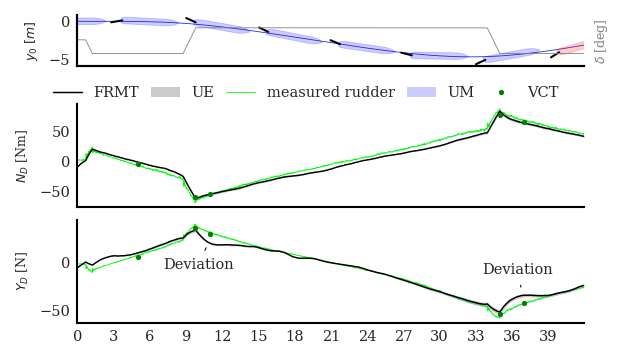

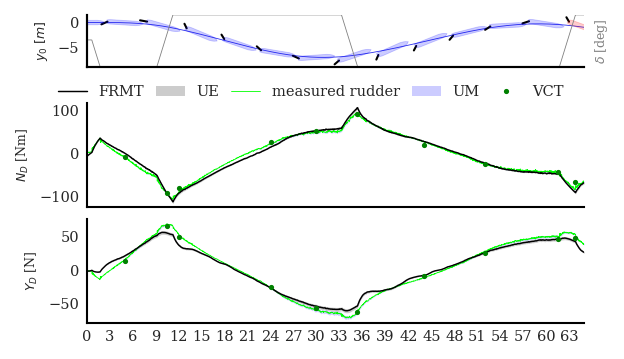

In [268]:
t_maxs = {
    23590 : 42, 
    23594 : 65,
}

units_ = units.copy()
units_.pop('Y_R')

models_ = pd.Series(models)
models_ = models_.drop('MMG_original')
models_ = models_.drop('MMG_quadratic')


for id, meta_data in meta_datas.loc[[23590,23594]].iterrows():
    
    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)
    df_EKF_smooth['X_RM'] = df_EKF_smooth['Rudder/1/Fx']
    df_EKF_smooth['Y_RM'] = df_EKF_smooth['Rudder/1/Fy']

    df_EKF_smooth = df_EKF_smooth.loc[0:t_maxs.get(id,np.inf)]
    
    #keys=['N_D','Y_D','alpha']
    keys=['N_D','Y_D',]
    fig = plot_compare_model_forces(model=model, models=models_, data=df_EKF_smooth, styles=styles, keys=keys, delta_corners=False, units=units_, symbols=symbols);

    # Model test uncertainty
    data = model.forces_from_motions(data=df_EKF_smooth)
    for key,ax,percentage in zip(['N_D','Y_D',],fig.axes[1:],[3.5,5]):
        y1=data[key]*(1-percentage/100)
        y2=data[key]*(1+percentage/100)
        ax.fill_between(x=data.index, y1=y1, y2=y2, zorder=-1000, color='k', alpha=0.2, linewidth=0, label='UE')
        
    # Monte Carlo:
    for key,ax in zip(['N_D','Y_D',],fig.axes[1:]):
        df_boundaries = monte_carlos[id][key]
        ax.fill_between(x=df_boundaries.index, y1=df_boundaries['lower'], y2=df_boundaries['higher'], zorder=-1000, color='b', alpha=0.2, linewidth=0, label='UM')
    
    direction = "port" if meta_data['angle'] > 0 else "stbd"
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
    #fig.suptitle(name)


    if (points_all['id']==id).any():
        points = points_all.groupby(by='id').get_group(id)
        for ax,key in zip(fig.axes[1:],keys):
            if key in points:
                points.plot(y=key,style='g.',ax=ax, label='VCT', zorder=100)


    if id==23590:
        fig.axes[2].annotate("Deviation", xy=(10.8,20), xytext=(10,-10), 
                    size=7, arrowprops=dict(arrowstyle='-',lw=0.5), horizontalalignment='center',verticalalignment='bottom')

        fig.axes[2].annotate("Deviation", xy=(36.8,-30), xytext=(36.5,0), 
                    size=7, arrowprops=dict(arrowstyle='-',lw=0.5), horizontalalignment='center',verticalalignment='top')

        
    
    fig.axes[1].legend(loc='upper left', ncols=5)
    for ax in fig.axes[2:]:
        try:
            ax.get_legend().set_visible(False)
        except:
            pass


    for ax in fig.axes[0:-1]:
        ax.set_xlabel('')
    fig.axes[-1].set_xlabel('Time [s]')
    
    #fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.45, 1.30), ncol=4)
    handles, labels = fig.axes[1].get_legend_handles_labels()
    legends = pd.Series(index=labels, data=handles)
    legends = legends[['FRMT', 'UE', 'measured rudder', 'UM', 'VCT']]
    fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.45, 1.30), ncol=5, columnspacing=0.8,  handles=list(legends.values))


    
    loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
    for ax in fig.axes:
        ax.xaxis.set_major_locator(loc)
        ax.grid(True, axis='x')
        ax.grid(False, axis='y')
        ax.grid(False)

    fig.set_size_inches(paper.figure_width*0.75,0.75*paper.figure_height)
    
    name = f"measured_rudder_{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
    #fig.suptitle(name)
        
    file_name = name.replace("/","_")
    paper.save_fig(fig, f"{file_name}.svg")

[04/15/25 09:02:56] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=318630;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=910356;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=834082;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=528949;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[04/15/25 09:02:57] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=622266;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=723127;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=314397;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=687199;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

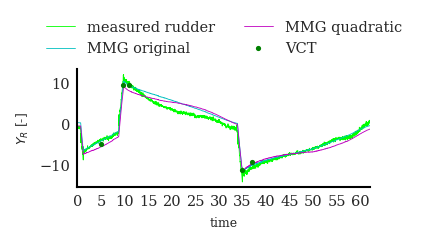

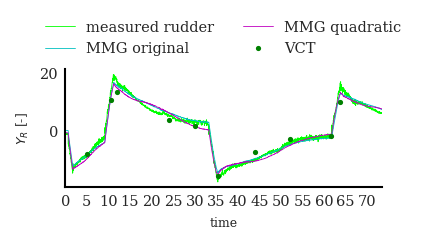

In [257]:
t_maxs = {
    #23590 : 42, 
    #23594 : 65,
}
units_ = units.copy()
units_.pop('Y_R')
for id, meta_data in meta_datas.loc[[23590,23594]].iterrows():
#for id, meta_data in meta_datas.loc[[23594]].iterrows():
#for id, meta_data in meta_datas.iterrows():   
    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)
    df_EKF_smooth['X_RM'] = df_EKF_smooth['Rudder/1/Fx']
    df_EKF_smooth['Y_RM'] = df_EKF_smooth['Rudder/1/Fy']

    df_EKF_smooth = df_EKF_smooth.loc[0:t_maxs.get(id,np.inf)]
    
    keys=['Y_R']
    fig = plot_compare_model_forces(model=model, models=models, data=df_EKF_smooth, styles=styles, keys=keys, delta_corners=False, units=units_, 
                                    symbols=symbols, do_track_plot=False);
    if (points_all['id']==id).any():
        points = points_all.groupby(by='id').get_group(id)
        for ax,key in zip(fig.axes,keys):
            if key in points:
                points.plot(y=key,style='g.',ax=ax, label='VCT', zorder=100)

    fig.set_size_inches(paper.figure_width,0.5*paper.figure_height)
    #fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.50, 1.20), ncol=4)
    
    loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
    for ax in fig.axes:
        ax.xaxis.set_major_locator(loc)
        ax.grid(True, axis='x')
        ax.grid(False, axis='y')
        ax.grid(False)
        #ax.legend(loc='lower center', ncols=2)
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1), ncols=2)

    fig.set_size_inches(paper.figure_width*0.5,0.5*paper.figure_height)
    
    name = f"rudder_forces_{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
    #fig.suptitle(name)
        
    file_name = name.replace("/","_")
    paper.save_fig(fig, f"{file_name}.svg")

[04/15/25 08:27:02] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=706037;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=601176;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=380851;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=954086;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

<Axes: xlabel='time'>

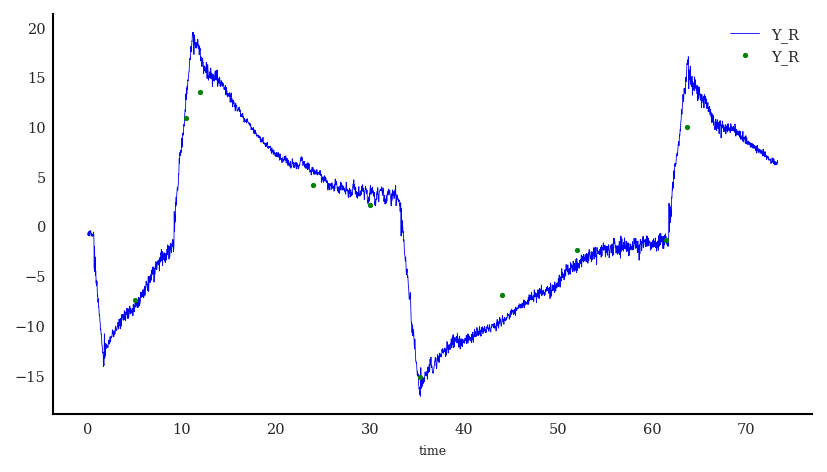

In [172]:
id = 23594
df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)
df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)
df_EKF_smooth['Y_R'] = df_EKF_smooth['Rudder/1/Fy']

df_ = points_all.groupby(by='id').get_group(id)

fig,ax=plt.subplots()
df_EKF_smooth.plot(y='Y_R', style='b-',ax=ax)
df_.plot(y='Y_R', style='g.',ax=ax)


[04/15/25 09:03:06] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=568890;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=560853;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=400089;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=683728;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[04/15/25 09:03:07] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=550617;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=503044;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=759039;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=299584;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

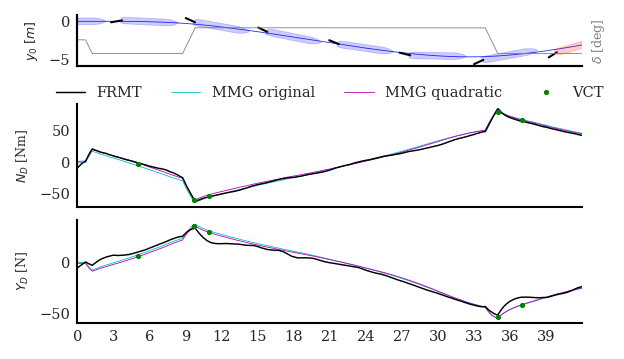

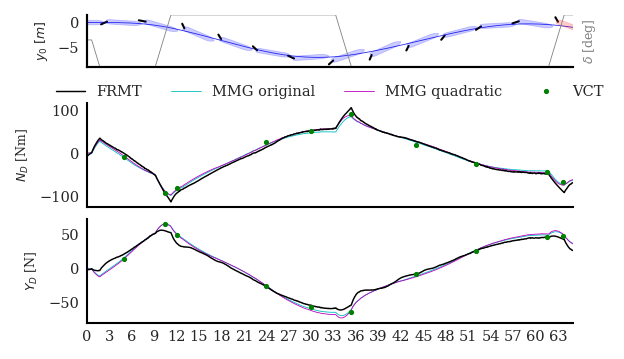

In [258]:
t_maxs = {
    23590 : 42, 
    23594 : 65,
}

units_ = units.copy()
units_.pop('Y_R')

models_ = pd.Series(models)
models_ = models_.drop('measured rudder')

for id, meta_data in meta_datas.loc[[23590,23594]].iterrows():
    
    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)
    df_EKF_smooth['X_RM'] = df_EKF_smooth['Rudder/1/Fx']
    df_EKF_smooth['Y_RM'] = df_EKF_smooth['Rudder/1/Fy']

    df_EKF_smooth = df_EKF_smooth.loc[0:t_maxs.get(id,np.inf)]
    
    #keys=['N_D','Y_D','alpha']
    keys=['N_D','Y_D',]
    fig = plot_compare_model_forces(model=model, models=models_, data=df_EKF_smooth, styles=styles, keys=keys, delta_corners=False, units=units_, symbols=symbols);
   
    
    direction = "port" if meta_data['angle'] > 0 else "stbd"
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
    #fig.suptitle(name)


    if (points_all['id']==id).any():
        points = points_all.groupby(by='id').get_group(id)
        for ax,key in zip(fig.axes[1:],keys):
            if key in points:
                points.plot(y=key,style='g.',ax=ax, label='VCT', zorder=100)


    #if id==23594:
    #    for i,ax in enumerate(fig.axes):
#
    #        if i==0:
    #            continue
    #        
    #        ylims = ax.get_ylim()
    #        ax.fill([43,43,62,62], [ylims[0],ylims[1],ylims[1],ylims[0]], color='blue', edgecolor=None, alpha=0.1, zorder=-100)
#
    #    for i,ax in enumerate(fig.axes):
#
    #        if i==0:
    #            continue
    #        
    #        ylims = ax.get_ylim()
    #        ax.fill([23,23,33.3,33.3], [ylims[0],ylims[1],ylims[1],ylims[0]], color='blue', edgecolor=None, alpha=0.1, zorder=-100)
#
    #if id==23590:
    #    fig.axes[2].annotate("Deviation", xy=(10.8,20), xytext=(10,-10), 
    #                size=7, arrowprops=dict(arrowstyle='-',lw=0.5), horizontalalignment='center',verticalalignment='bottom')
#
    #    fig.axes[2].annotate("Deviation", xy=(36.8,-30), xytext=(36.5,0), 
    #                size=7, arrowprops=dict(arrowstyle='-',lw=0.5), horizontalalignment='center',verticalalignment='top')

        
    
    fig.axes[1].legend(loc='upper left', ncols=5)
    for ax in fig.axes[2:]:
        try:
            ax.get_legend().set_visible(False)
        except:
            pass


    for ax in fig.axes[0:-1]:
        ax.set_xlabel('')
    fig.axes[-1].set_xlabel('Time [s]')
    
    fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.50, 1.30), ncol=4)


    
    loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
    for ax in fig.axes:
        ax.xaxis.set_major_locator(loc)
        ax.grid(True, axis='x')
        ax.grid(False, axis='y')
        ax.grid(False)

    fig.set_size_inches(paper.figure_width*0.75,0.75*paper.figure_height)
    
    
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
    #fig.suptitle(name)
        
    file_name = name.replace("/","_")
    paper.save_fig(fig, f"{file_name}.svg")
    

In [174]:
data = df_EKF_smooth
forces_from_motions = model.forces_from_motions(data=data)
force_predictions = {name:predict(model=model, data=data) for name, model in models.items()}

In [175]:
keys = ['Y_D','N_D']
_ = []
for name, df_prediction in force_predictions.items():
    score = pd.Series(name=name)
    for key in keys:
        score[key] = np.sqrt(r2_score(y_true=forces_from_motions[key], y_pred=df_prediction[key]))

    _.append(score)

scores = pd.DataFrame(_)


In [176]:
scores

,Y_D,N_D
measured rudder,0.982954,0.993419
MMG_original,0.987724,0.992138
MMG_quadratic,0.984061,0.994499


(0.9629535841632788, 1.0)

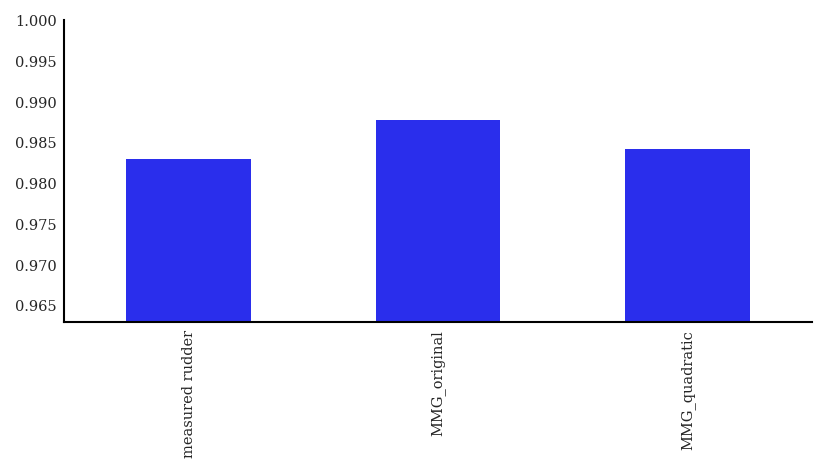

In [177]:
fig,ax=plt.subplots()
scores['Y_D'].plot.bar(ax=ax)
ax.set_ylim(scores['Y_D'].min()-0.02,1)


(0.9629535841632788, 1.0)

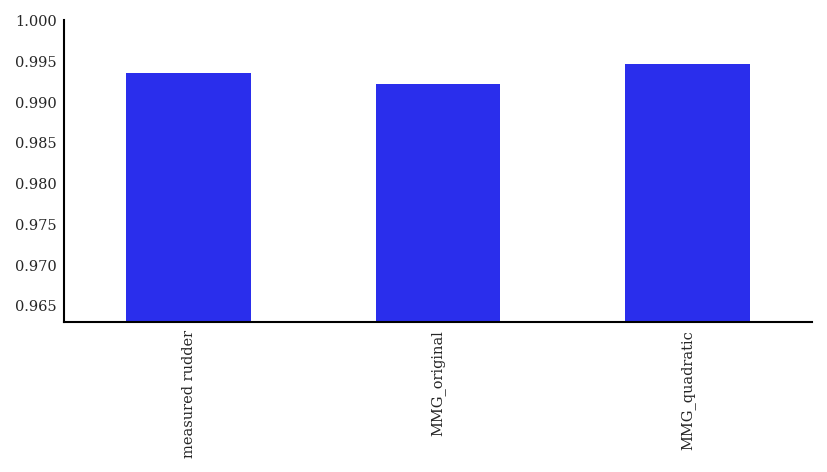

In [178]:
fig,ax=plt.subplots()
scores['N_D'].plot.bar(ax=ax)
ax.set_ylim(scores['Y_D'].min()-0.02,1)

(0.9649126650375308, 1.0)

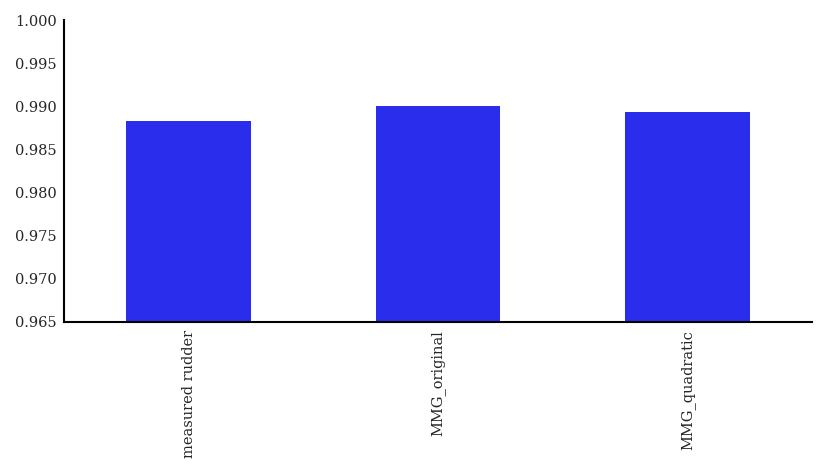

In [179]:
fig,ax=plt.subplots()
scores.mean(axis=1).plot.bar()
ax.set_ylim(scores.mean().min().min()-0.02,1)


## Closed loop simulation

In [180]:
meta_datas['angle_abs'] = meta_datas['angle'].abs()

[04/15/25 08:27:07] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=867592;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=158113;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=575201;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=381524;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

'zigzag 20_20 port'

[04/15/25 08:27:09] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=412742;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=1986;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=211595;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=481240;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[04/15/25 08:27:11] WARNING  No artists with labels found to put in legend.  Note that artists whose ]8;id=81185;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py\legend.py]8;;\:]8;id=305565;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py#1363\1363]8;;\
                             label start with an underscore are ignored when legend() is called with               
                             no argument.                                                                          

'zigzag 20_20 stbd'

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=392571;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=27099;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=119331;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=265728;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

'zigzag 10_10 port'

[04/15/25 08:27:13] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=495153;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=858344;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=440042;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=195714;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[04/15/25 08:27:15] WARNING  No artists with labels found to put in legend.  Note that artists whose ]8;id=739824;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py\legend.py]8;;\:]8;id=221013;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py#1363\1363]8;;\
                             label start with an underscore are ignored when legend() is called with               
                             no argument.                                                                          

'zigzag 10_10 stbd'

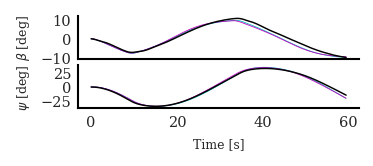

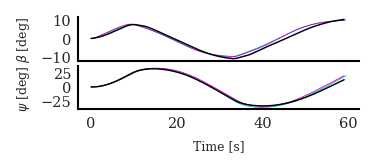

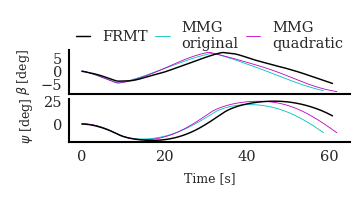

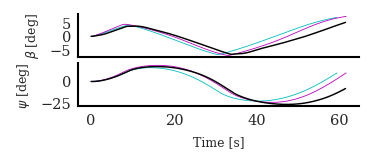

In [181]:
simulations = {}

first = True
for angle, group in meta_datas.sort_values(by=['angle_abs','angle'], ascending=False).groupby(by='angle1', sort=False):

    #fig,ax=plt.subplots()
    include_label=True
    
    for id, meta_data in group.iterrows():
    
        df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
        df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
        df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)
    
        df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)
        df_EKF_smooth['X_RM'] = df_EKF_smooth['Rudder/1/Fx']
        df_EKF_smooth['Y_RM'] = df_EKF_smooth['Rudder/1/Fy']

    
        dataframes = {'Experiment':df_EKF_smooth}
        
        for model_name, model in models.items():

            data = preprocess(df_EKF_smooth,ship_data=model.ship_parameters)
            angle = zigzag_angle(data_MDL=data)
        
            if model_name == "measured rudder":
                #df_simulation = model.simulate(data)
                continue
            else:
                df_simulation = simulate_closed_loop(model=model,data=data)

            if not id in simulations:
                simulations[id] = {}

            simulations[id][model_name] = df_simulation
            
            direction = "port" if angle > 0 else "stbd"
            name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction} {model_name}"
        
            dataframes[model_name] = df_simulation

        dataframes['Experiment'] = dataframes['Experiment'].loc[-1:df_simulation.index[-1]].copy()
        
        #track_plots(dataframes, lpp=model.ship_parameters['L'], beam=model.ship_parameters['B'], include_wind=False, styles=styles, ax=ax, include_label=include_label);
        #fig = ax.get_figure()
        
        direction = "port" if angle > 0 else "stbd"
        name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
        #fig.suptitle(name)
        #file_name = name.replace("/","_")
        #paper.save_fig(fig, f"track plot {file_name}.svg")
        
        fig = plot(dataframes, keys=['psi','beta'], units=units, styles=styles, ncols=1, include_label=include_label, symbols=symbols);
        name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
        for ax in fig.axes:
            ax.grid(False)

        fig.set_size_inches(paper.figure_width*0.40,0.25*paper.figure_height)
        
        #fig.axes[0].get_legend().set_visible(False)
        
        #fig.suptitle(name)
        file_name = name.replace("/","_")
        
        if file_name == 'zigzag 10_10 port':
            fig.axes[0].legend(['FRMT','MMG\noriginal','MMG\nquadratic'], loc='upper center', bbox_to_anchor=(0.5, 2), ncol=3, columnspacing=0.5, handlelength=1)
        else:
            fig.axes[0].get_legend().set_visible(False)
        
        paper.save_fig(fig, f"closed loop {file_name}.svg",  bbox_inches='tight')
        display(file_name)
        
        
        include_label=False

In [182]:
mask = pd.notnull(meta_datas_all['angle'])
meta_datas_all = meta_datas_all.loc[mask].copy()

meta_datas_all[['angle','comment']]

,angle,comment
23590,-10.0,ZZ10/10 SB
23591,10.0,ZZ10/10 SB
23592,-10.0,ZZ10/10 SB
23593,10.0,ZZ10/10 PS
23594,-20.0,ZZ20/20 SB
23595,-20.0,ZZ20/20 SB
23596,20.0,ZZ20/20 PS
23597,20.0,ZZ20/20 PS
23679,-10.0,ZZ10/10 SB
23680,10.0,ZZ10/10 PS


In [183]:
IMO_evaluation.measure_overshoots(df_simulation)


16.05     8.980508
43.58    14.781274
Name: psi, dtype: float64

In [184]:
IMO_evaluation.measure_overshoots(df_EKF_smooth)


time
15.860022     7.432821
47.220002    17.138650
Name: psi, dtype: float64

In [185]:
def pack_overshoots(overshoots):
    overshoot_result = {}
    for n,(time, overshoot) in enumerate(overshoots.items()):  
        overshoot_result[f'overshoot_{n+1}'] = overshoot
        overshoot_result[f't_{n+1}'] = time

    return overshoot_result

In [186]:
_ = []
for id, meta_data in meta_datas_all.iterrows():
    
    try:
        df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    except:
        continue
    #df_EKF_smooth = catalog.load(f"{ship_name}.tests")[str(id)]()
    
    overshoots = IMO_evaluation.measure_overshoots(df_EKF_smooth, angle=meta_data['angle'])
    overshoot_result = pack_overshoots(overshoots)
    overshoot_result = pd.Series(overshoot_result, name=id)
    overshoot_result['angle'] = meta_data['angle']
    
    
    _.append(overshoot_result)
    
overshoot_results = pd.DataFrame(_)

[04/15/25 08:27:16] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=178709;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=729888;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=114499;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=969845;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=681477;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=683153;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=706444;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=214095;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=42126;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=254522;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=146420;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=812936;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=743195;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=431876;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=718511;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=676492;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=741083;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=475185;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=53819;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=398386;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=692378;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=867798;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=13474;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=975536;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [187]:
overshoot_results.sort_values(by='angle')

,overshoot_1,t_1,overshoot_2,t_2,angle,overshoot_3,t_3
23594,12.275516,15.180002,13.988310,40.799998,-20.0,10.929683,68.279999
23595,12.687193,15.399989,14.028674,41.460002,-20.0,10.805342,68.809988
23682,12.451062,15.340005,13.836021,41.039996,-20.0,11.003151,68.630016
23590,7.432821,16.550008,17.138650,47.909988,-10.0,NaN,NaN
23592,7.625012,17.079992,17.168450,47.769985,-10.0,NaN,NaN
23679,7.886254,17.329988,17.687529,49.059983,-10.0,NaN,NaN
23591,8.464648,17.709999,15.291949,47.250018,10.0,NaN,NaN
23593,8.537342,17.669989,15.042208,47.099989,10.0,NaN,NaN
23680,8.724413,17.660002,14.986429,47.369995,10.0,NaN,NaN
23596,14.046294,15.659982,12.413888,41.269992,20.0,12.360698,68.659995


In [188]:
meta_data['angle']

-20.0

In [189]:
overshoot_results['id'] = overshoot_results.index

<Axes: xlabel='id'>

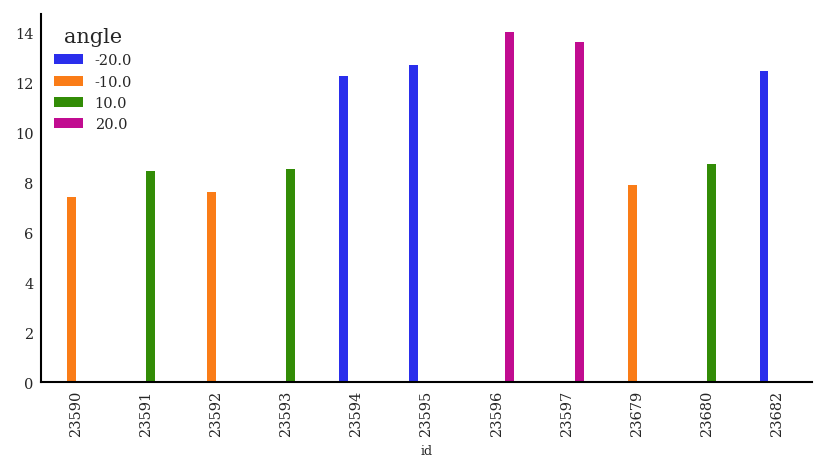

In [190]:
overshoot_results.pivot(index='angle', columns='id', values='overshoot_1').transpose().plot.bar()

<Axes: xlabel='angle'>

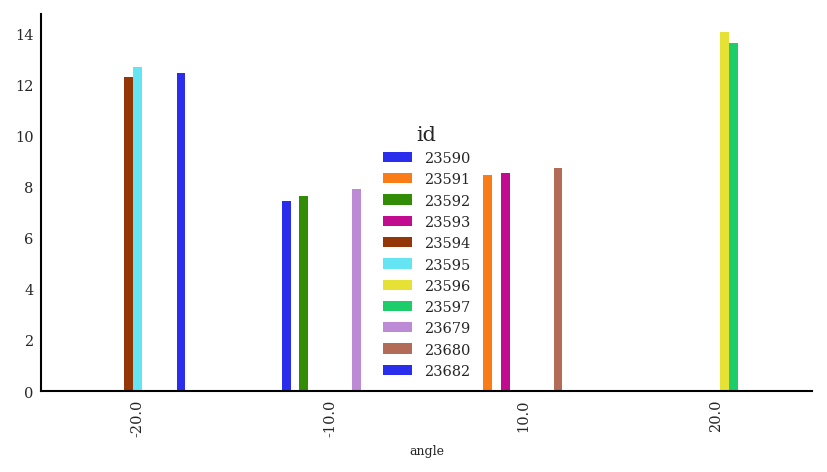

In [191]:
overshoot_results.pivot(index='angle', columns='id', values='overshoot_1').plot.bar()

In [192]:
overshoot_experiment_mean = overshoot_results.groupby(by='angle').mean()
overshoot_experiment_mean['model_name'] = 'Experiment'
overshoot_experiment_mean['angle'] = overshoot_experiment_mean.index

In [193]:
overshoot_results.groupby(by='angle').std()

,overshoot_1,t_1,overshoot_2,t_2,overshoot_3,t_3,id
angle,,,,,,,
-20.0,0.206580,0.113720,0.101601,0.334068,0.099988,0.269503,50.520623
-10.0,0.227591,0.398278,0.308653,0.707835,NaN,NaN,50.816664
10.0,0.134014,0.026458,0.162699,0.135281,NaN,NaN,50.816664
20.0,0.302530,0.070699,0.168781,0.127267,0.155845,0.028285,0.707107


In [194]:
_ = []
for id, model_simulations in simulations.items():

    meta_data = meta_datas_all.loc[id]
    
    for model_name, df_simulation in model_simulations.items():
        
        overshoots = IMO_evaluation.measure_overshoots(df_simulation, angle=meta_data['angle'])
        overshoot_result = pack_overshoots(overshoots)
        overshoot_result['id'] = id
        overshoot_result['model_name'] = model_name
        overshoot_result['angle'] = meta_data['angle']
        _.append(overshoot_result)
    
overshoot_simulation_results = pd.DataFrame(_)
overshoot_simulation_results = pd.concat((overshoot_simulation_results,overshoot_experiment_mean,))

In [195]:
overshoot_simulation_results['angle'] = overshoot_simulation_results['angle'].astype(int)

In [196]:
overshoot_simulation_results

,overshoot_1,t_1,overshoot_2,t_2,id,model_name,angle,overshoot_3,t_3
0.0,14.337090,15.320000,14.539594,40.400000,23596.000000,MMG_original,20,NaN,NaN
1.0,13.976212,15.330000,14.012001,40.190000,23596.000000,MMG_quadratic,20,NaN,NaN
2.0,12.609471,14.950000,16.792967,39.760000,23594.000000,MMG_original,-20,NaN,NaN
3.0,13.436154,15.150000,14.795128,40.190000,23594.000000,MMG_quadratic,-20,NaN,NaN
4.0,6.947730,14.680000,11.546515,40.540000,23591.000000,MMG_original,10,NaN,NaN
5.0,7.740813,15.130000,15.293607,42.780000,23591.000000,MMG_quadratic,10,NaN,NaN
6.0,6.232068,14.350000,13.262416,40.260000,23590.000000,MMG_original,-10,NaN,NaN
7.0,8.980508,16.050000,14.781274,43.580000,23590.000000,MMG_quadratic,-10,NaN,NaN
-20.0,12.471257,15.306665,13.951002,41.099999,23623.666667,Experiment,-20,10.912725,68.573334
-10.0,7.648029,16.986663,17.331543,48.246652,23620.333333,Experiment,-10,NaN,NaN


In [197]:
styles


{
    'VCT': {'style': 'k.', 'zorder': 100, 'lw': 0.7, 'label': 'VCT'},
    'Experiment': {'style': 'k-', 'zorder': 100, 'lw': 0.7, 'label': 'FRMT'},
    'polynomial rudder': {'style': '-', 'color': 'red', 'label': 'polynomial rudder'},
    'semiempirical rudder': {'style': '-', 'color': '#0000ff', 'label': 'semi-empirical rudder'},
    'measured rudder': {
        'style': '-',
        'color': '#00ff00',
        'zorder': -100,
        'alpha': 1,
        'label': 'measured rudder'
    },
    'MMG_rudder': {'style': 'm-', 'label': 'MMG rudder'},
    'MMG_original': {'style': 'c-', 'label': 'MMG original'},
    'MMG_quadratic': {'style': 'm-', 'label': 'MMG quadratic'}
}

In [198]:
def get_name(row):
    angle = row.name
    direction = "port" if angle > 0 else "stbd"
    name = f"{abs(angle):0.0f}/{abs(angle):0.0f} {direction}"
    return name

In [199]:
def get_colors(overshoot_simulation_results_pivot):
    colors = []
    for name in overshoot_simulation_results_pivot.columns:
        if name=='name':
            continue
    
        style= styles[name]
        color = style.get('color',style['style'][0])
        colors.append(color)
    return colors

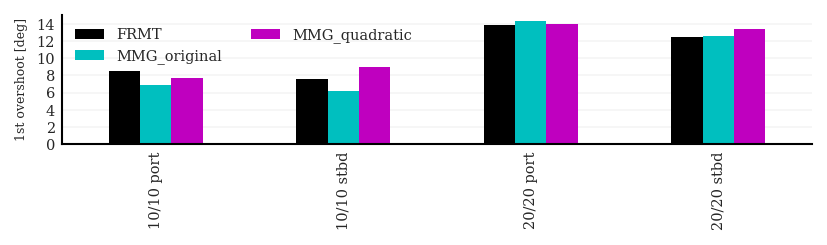

In [200]:
fig,ax=plt.subplots()
fig.set_size_inches((paper.figure_width,paper.figure_height/2))

overshoot_simulation_results_pivot = overshoot_simulation_results.pivot_table(index='angle', columns='model_name', values='overshoot_1')
colors = get_colors(overshoot_simulation_results_pivot)

overshoot_simulation_results_pivot['name'] = overshoot_simulation_results_pivot.apply(get_name, axis=1)
overshoot_simulation_results_pivot.sort_values(by='name', inplace=True)
overshoot_simulation_results_pivot.rename(columns={'Experiment':'FRMT'}, inplace=True)
overshoot_simulation_results_pivot.plot.bar(x='name', color=colors, ax=ax)
ax.legend(ncols=2)
ax.set_xlabel('')
ax.set_ylabel('1st overshoot [deg]')

loc = plticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.grid(True, axis='y', which='major')

paper.save_fig(fig,"overshoot1.svg")

In [201]:
df_overshoot_diff = overshoot_simulation_results_pivot.select_dtypes(exclude='object').sub(overshoot_simulation_results_pivot['FRMT'],axis=0)
df_overshoot_diff.abs().mean(numeric_only=True)


model_name
FRMT             0.000000
MMG_original     0.921657
MMG_quadratic    0.818968
dtype: float64

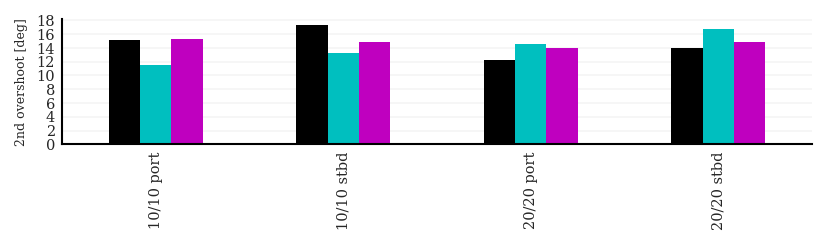

In [202]:
fig,ax=plt.subplots()
fig.set_size_inches((paper.figure_width,paper.figure_height/2))

overshoot_simulation_results_pivot = overshoot_simulation_results.pivot_table(index='angle', columns='model_name', values='overshoot_2')

overshoot_simulation_results_pivot['name'] = overshoot_simulation_results_pivot.apply(get_name, axis=1)
overshoot_simulation_results_pivot.sort_values(by='name', inplace=True)
overshoot_simulation_results_pivot.rename(columns={'Experiment':'FRMT'}, inplace=True)
overshoot_simulation_results_pivot.plot.bar(x='name', color=colors, ax=ax)

#ax.legend(ncols=3)
ax.get_legend().set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('2nd overshoot [deg]')

loc = plticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.grid(True, axis='y', which='major')

paper.save_fig(fig,"overshoot2.svg")

In [203]:
overshoot_simulation_results_pivot

model_name,FRMT,MMG_original,MMG_quadratic,name
angle,,,,
10,15.106862,11.546515,15.293607,10/10 port
-10,17.331543,13.262416,14.781274,10/10 stbd
20,12.294542,14.539594,14.012001,20/20 port
-20,13.951002,16.792967,14.795128,20/20 stbd


In [204]:
df_overshoot_diff

model_name,FRMT,MMG_original,MMG_quadratic
angle,,,
10,0.0,-1.627738,-0.834655
-10,0.0,-1.415961,1.332480
20,0.0,0.504717,0.143840
-20,0.0,0.138214,0.964896


In [205]:
df_overshoot_diff.abs().mean(axis=0)


model_name
FRMT             0.000000
MMG_original     0.921657
MMG_quadratic    0.818968
dtype: float64